### Other encoded assets

In [2]:
# Input
date = '2018_09_21'
homePath = 'C:/Users/Mamed/Python4DS/'
projPath = homePath + 'FundsBR/'
strucPath = projPath + 'Structures_' + date + '/'
libsPath = projPath + 'Libs/'

In [3]:
import pandas as pd
import numpy as np
from collections import Counter
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import gridspec
from IPython.display import clear_output
import copy

# Load my libraries
exec(open(libsPath + 'fundsLib.py').read())

#### Other encoded assets (blk 4)

In [4]:
# Read BLC
dfBLC = pd.read_pickle(strucPath + 'BLC_blk_4_.pkl')
l0 = dfBLC.shape[0]
print('{:>12,.0f} rows {:>6,.0f} columns'.format(dfBLC.shape[0], dfBLC.shape[1]))

   7,723,080 rows     21 columns


In [5]:
# Summary
dfSummary(dfBLC)

RangeIndex: 7723080 entries, 0 to 7723079
Data columns (total 21 columns):

                    colType   Unique      NaN
TP_FUNDO             object       13        0
CNPJ_FUNDO           object    10771        0
DENOM_SOCIAL         object    10781        0
DT_COMPTC            object      164        0
TP_APLIC             object       19        0
TP_ATIVO             object       35    86236
EMISSOR_LIGADO       object        2  1770859
TP_NEGOC             object        2        2
QT_VENDA_NEGOC      float64   164144  2507686
VL_VENDA_NEGOC      float64  1782965  2451471
QT_AQUIS_NEGOC      float64   166026  2506367
VL_AQUIS_NEGOC      float64  1913017  2450148
QT_POS_FINAL        float64   530453    86236
VL_MERC_POS_FINAL   float64  3768215        0
VL_CUSTO_POS_FINAL  float64   604083  6747240
DT_CONFID_APLIC      object      753  3449868
CD_ATIVO             object    23613    86236
DS_ATIVO             object     2146    86236
CD_ISIN              object    26424   376621
DT_I

In [6]:
# The confidentiality period (last 3 months) will have null 'CD_ATIVO',
# i.e., for that dates, we will not be able to see the assets.
# Therefore, we delete those rows.
dfBLC = dfBLC[~dfBLC['CD_ATIVO'].apply(pd.isnull)].reset_index(drop = True)
l1 = dfBLC.shape[0]
print('Deleted rows: {:<20,.0f}'.format(l0 - l1))

Deleted rows: 86,236              


In [7]:
# Four date columns have to be convervet from string to datestamp
dfBLC['DT_COMPTC'] = pd.to_datetime(dfBLC['DT_COMPTC'])
dfBLC['DT_CONFID_APLIC'] = pd.to_datetime(dfBLC['DT_CONFID_APLIC'])
dfBLC['DT_INI_VIGENCIA'] = pd.to_datetime(dfBLC['DT_INI_VIGENCIA'])

# No that differently of other assets blocks, in this case we have stocks.
# For them, the fild 'DT_FIM_VIGENCIA' sometimes is filled with the value
# '9999-12-31'. For that reason, we need to include the "errors = 'coerce'"
# option in the dates convertion function. In that case, the '9999' dates
# will be converted as 'NaT', otherwise it would raise an error.
dfBLC['DT_FIM_VIGENCIA'] = pd.to_datetime(dfBLC['DT_FIM_VIGENCIA'], 
    errors = 'coerce')

In [8]:
# Summary
dfSummary(dfBLC)

RangeIndex: 7636844 entries, 0 to 7636843
Data columns (total 21 columns):

                           colType   Unique      NaN
TP_FUNDO                    object       13        0
CNPJ_FUNDO                  object    10734        0
DENOM_SOCIAL                object    10744        0
DT_COMPTC           datetime64[ns]      164        0
TP_APLIC                    object       19        0
TP_ATIVO                    object       35        0
EMISSOR_LIGADO              object        2  1767657
TP_NEGOC                    object        2        2
QT_VENDA_NEGOC             float64   164144  2421450
VL_VENDA_NEGOC             float64  1766409  2421450
QT_AQUIS_NEGOC             float64   166026  2420131
VL_AQUIS_NEGOC             float64  1894454  2420131
QT_POS_FINAL               float64   530453        0
VL_MERC_POS_FINAL          float64  3719084        0
VL_CUSTO_POS_FINAL         float64   604080  6661012
DT_CONFID_APLIC     datetime64[ns]      747  3449868
CD_ATIVO               

In [9]:
seriesSummary(dfBLC, 'TP_APLIC', 0, 50, 'head')

Ações                                                 5185288
Obrigações por ações e outros TVM recebidos em emp     586278
Mercado Futuro - Posições vendidas                     454158
Ações e outros TVM cedidos em empréstimo               409230
Mercado Futuro - Posições compradas                    337659
Opções - Posições titulares                            153226
Debêntures                                             129151
Certificado ou recibo de depósito de valores mobil     127255
Opções - Posições lançadas                             119271
Vendas a termo a receber                                58969
Debêntures simples                                      36889
Brazilian Depository Receipt - BDR                      11755
Outros valores mobiliários registrados na CVM obje      10533
Compras a termo a receber                                9282
Outras aplicações                                        6152
Investimento no Exterior                                 1100
Debêntur

In [10]:
seriesSummary(dfBLC, 'TP_ATIVO', 0, 0, 'head')

Ação ordinária                            3579017
Ação preferencial                         2645515
Futuro de DI1:DI de 1 dia                  356602
Contrato Futuro                            343483
Opção de compra                            166201
Debênture simples                          165801
Certificado de depósito de ações           146068
Opção de venda                             106296
Futuro de DOL:Dólar comercial               37517
Futuro de IND:Ibovespa                      23674
Futuro de DDI:Cupom cambial                 21936
Recibo de subscrição                        16109
BDR nível III                                8626
BDR nível I                                  3129
Bônus de subscrição                          3018
Futuro de WIN:Ibovespa futuro                2134
Futuro de DAP:Cupom de DI x IPCA             2081
Brazilian Repository Receipt                 2002
Futuro de BGI:Boi gordo                      1504
Título da Dívida Externa                     1100


### Stocks

In [13]:
# We will look separately to Stocks
dfStk = dfBLC[dfBLC['TP_APLIC'] == 'Ações'].reset_index(drop = True)
print('{:>12,.0f} rows {:>6,.0f} columns'.format(dfStk.shape[0], dfStk.shape[1]))

   5,185,288 rows     21 columns


In [12]:
dfSummary(dfStk)

RangeIndex: 5185288 entries, 0 to 5185287
Data columns (total 21 columns):

                           colType   Unique      NaN
TP_FUNDO                    object       12        0
CNPJ_FUNDO                  object     6577        0
DENOM_SOCIAL                object     6584        0
DT_COMPTC           datetime64[ns]      164        0
TP_APLIC                    object        1        0
TP_ATIVO                    object        2        0
EMISSOR_LIGADO              object        2   738118
TP_NEGOC                    object        2        0
QT_VENDA_NEGOC             float64   162080   514218
VL_VENDA_NEGOC             float64  1679252   514218
QT_AQUIS_NEGOC             float64   164278   514186
VL_AQUIS_NEGOC             float64  1807293   514186
QT_POS_FINAL               float64   465832        0
VL_MERC_POS_FINAL          float64  2573141        0
VL_CUSTO_POS_FINAL         float64   470148  4447170
DT_CONFID_APLIC     datetime64[ns]      705  2380473
CD_ATIVO               

#### Stocks' lifespan, i.e., time between first and last apperance in the database

In [233]:
# Asset lifeSpan
d = dfStk.groupby(['CD_ATIVO'])['DT_COMPTC']
dfLS = pd.DataFrame(data = [d.min(), d.max()], index = ['dtMin', 'dtMax']).T
dfLS['lifeSpan'] = dfLS['dtMax'] - dfLS['dtMin']
dfLS['lifeSpan'] = dfLS['lifeSpan'].apply(lambda x: x.days)

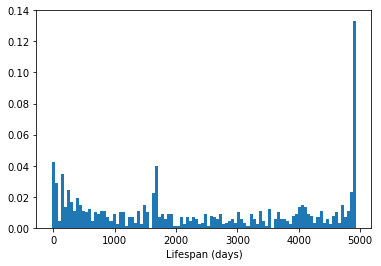

In [240]:
fig = plt.figure(figsize = (6, 4))
ax = fig.add_subplot(111)
hist, bins = np.histogram(dfLS['lifeSpan'], bins = 100)
plt.bar(bins[:-1], hist.astype(np.float32) / hist.sum(), 
        width = (bins[1] - bins[0]))
plt.xlabel('Lifespan (days)')
plt.show()

In [247]:
# 25% of the stocks (0.25 * 900 = 225) lived untill 730 days
# Note we had zero lifespan! I.e., one day only...
dfLS['lifeSpan'].describe()

count     900.000000
mean     2462.397778
std      1784.136876
min         0.000000
25%       730.000000
50%      2192.000000
75%      4209.000000
max      4960.000000
Name: lifeSpan, dtype: float64

#### A liquidity measure: How many fund had positions in each stock at least for one day?

In [244]:
liq = dfStk.groupby(['CD_ATIVO', 'CNPJ_FUNDO'])['CNPJ_FUNDO'].count()
liq = liq.unstack(level = 1)
liq = ~liq.applymap(np.isnan)
liq = liq.sum(axis = 1)
liq.name = 'liq'

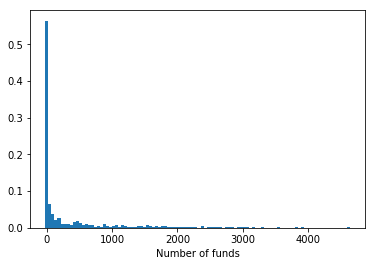

In [245]:
fig = plt.figure(figsize = (6, 4))
ax = fig.add_subplot(111)
hist, bins = np.histogram(liq, bins = 100)
plt.bar(bins[:-1], hist.astype(np.float32) / hist.sum(), 
        width = (bins[1] - bins[0]))
plt.xlabel('Number of funds')
plt.show()

In [248]:
# 25% of the stocks (0.25 * 900 = 225) have been traded in the maximum
# number of 3 funds. Is it the case of adventure capital? We have to 
# investigate.
# Note we had stocks traded only by one fund.
liq.describe()

count     900.000000
mean      355.462222
std       677.177940
min         1.000000
25%         3.000000
50%        28.000000
75%       367.500000
max      4659.000000
Name: liq, dtype: float64

#### How is the joint distribution of lifespan and liquidity?
Concentration in lifespans < 1500 and > 3500, for tradings number < 400.

In [250]:
df2 = pd.concat([dfLS['lifeSpan'], liq], axis=1)

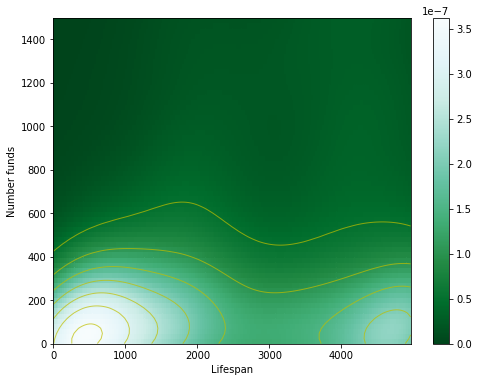

In [251]:
# Atention: the axes units are wrong
from scipy.stats import kde
fig = plt.figure(figsize = (8, 6))
ax = fig.add_subplot(111)

x = df2['lifeSpan']; y = df2['liq']

nbins = 200
k = kde.gaussian_kde([x,y])
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
im = plt.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.BuGn_r)
ax.contour(xi, yi, zi.reshape(xi.shape), colors = 'y', alpha = 0.7, 
    linewidths = 1)
fig.colorbar(im)

ax.set_ylim((0, 1500))
plt.xlabel('Lifespan')
plt.ylabel('Number funds')
    
plt.show()

In [ ]:
seriesSummary(dfStk, 'QT_POS_FINAL', 10, 0)

In [ ]:
seriesSummary(dfStk, 'CD_ATIVO', 10, 0, 'tail')

In [ ]:
seriesSummary(dfStk, 'DS_ATIVO', 10, 0, 'tail')

In [ ]:
seriesSummary(dfStk, 'CD_ISIN', 10, 0, 'head')

In [ ]:
# Deleting stocks which code has a frequency less than 10 in the hole data base
codeCount = dfStk['CD_ATIVO'].value_counts()

In [ ]:
len(codeCount)

In [ ]:
codeCount.describe()

In [ ]:
perc = 0.5
stkNames = codeCount.head(int(perc * len(codeCount))).index

In [ ]:
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(111)
plt.hist(codeCount, bins = 2500)
ax.set_xlim((0, 200))
plt.show()

In [ ]:
codeCount = codeCount[codeCount <= 10]

In [ ]:
codeCount

### Computing stocks unitary prices

In [ ]:
# Delete rows where 'QT_POS_FINAL' = 0
dfStk = dfStk[dfStk['QT_POS_FINAL'] != 0].reset_index(drop = True)

In [ ]:
# Compute unitary price column
dfStk['PU'] = dfStk['VL_MERC_POS_FINAL'] / dfStk['QT_POS_FINAL']

In [ ]:
# Compute the median for each stock CD_ATIVO and observation date

mode = lambda x: x.mode()# if len(x) > 2 else np.array(x)
#unitPrc = dfStk.groupby(['CD_ATIVO', 'DT_COMPTC'])['PU'].agg(mode)
unitPrc = dfStk.groupby(['CD_ATIVO', 'DT_COMPTC'])['PU'].mean()

In [ ]:
unitPrc.head(20)

In [ ]:
dfPrices = unitPrc.unstack(level = 0)

In [ ]:
dfPrices.head(5)

In [ ]:
dfPrices.iloc[:, 5]

In [ ]:
seriesSummary(dfPrices, 'ABYA3', 10, 0)

In [ ]:
stkCode = dfStk.groupby(['CD_ATIVO'])['TP_FUNDO'].count()
stkCode.head()

In [ ]:
stkCode.index

In [ ]:
# DF containg prices with dates in rows and ISIN code in columns
dfPrices = unitPrc.unstack(level = 0)

In [ ]:
fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot(111)

# Most frequent stocks
perc = 0.1
stkNames = codeCount.head(int(perc * len(codeCount))).index
print(int(perc * len(codeCount)))

# Plot price series for each bond 
for stk in dfPrices[stkNames]:
    
    plt.plot(dfPrices.index, dfPrices[stk], linewidth = 1.0, alpha = 0.5)

ax.set_ylim((0, 250))
plt.show()

### Combined gov. bonds and money market positions by fund

In [ ]:
# Funds Gov.Bonds position by ISIN and date (multi indices series)
titpub_by_fund = df_titpub.groupby(['DT_COMPTC', 'CNPJ_FUNDO', 'CD_ISIN'])['VL_MERC_POS_FINAL'].sum()
titpub_by_fund.name = 'govBonds'

In [ ]:
# Funds Money Market position by ISIN and date (multi indices series)
opcompr_by_fund = df_opcompr.groupby(['DT_COMPTC', 'CNPJ_FUNDO', 'CD_ISIN'])['VL_MERC_POS_FINAL'].sum()
opcompr_by_fund.name = 'moneyMrkt'

In [ ]:
# Gov. Bonds and Money Mrkt position by funds, ISIN and date (data frame)
dfPosition = pd.concat([titpub_by_fund, opcompr_by_fund], axis = 1)

In [ ]:
# Save data frame
dfPosition.to_pickle(strucPath + 'positions_dfs/govBonds_mmrkt.pkl')